In [13]:
import os
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import numpy as np
import math

In [42]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def exponential_model_log(x,a,b,c):
    return np.log10(exponential_model(x,a,b,c))

def get_exp_fit(country, deductedDaysNew = 0, movingAverageLength = 0):
    blackListedCountries = ["Iceland", "Diamond Princess", "Kazakhstan"]
    if country in blackListedCountries:
        return 0
    y = df.loc[country].values
    y = np.trim_zeros(y)
    
    ones = 0
    for i in y:
        if (i == 1):
            ones += 1
            
    y = y[ones:y.size]
    
    min = 10 if movingAverageLength == 0 else movingAverageLength
    if y.size - deductedDaysNew < min:
        return 0
    
    if movingAverageLength == 0:
        y = y[0:y.size - deductedDaysNew]
    else:
        y = y[y.size - deductedDaysNew - movingAverageLength:y.size - deductedDaysNew]
        #print(y)
    
    x = list(range(0,y.size,1))
    ylogged = [math.log(z,10) for z in y]
    exp_fit = curve_fit(exponential_model_log,x,ylogged,p0=[1,0.5,1],maxfev=10000)
    
    ymodel = []
    var = 0
    for i in x:
        var += ((exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) - y[i]) / exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]))**2
        ymodel.append(exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]))
    var /= y.size
    stddev = np.sqrt(var)
    
    return ([exp_fit[0][0],exp_fit[0][1]], stddev, x, y, ymodel)

In [23]:
csv = "../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

df = pd.read_csv(csv,index_col="Country/Region")
del df['Lat']
del df['Long']
del df['Province/State']

df = df.groupby(['Country/Region']).sum()

c:\users\simvel\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
c:\users\simvel\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


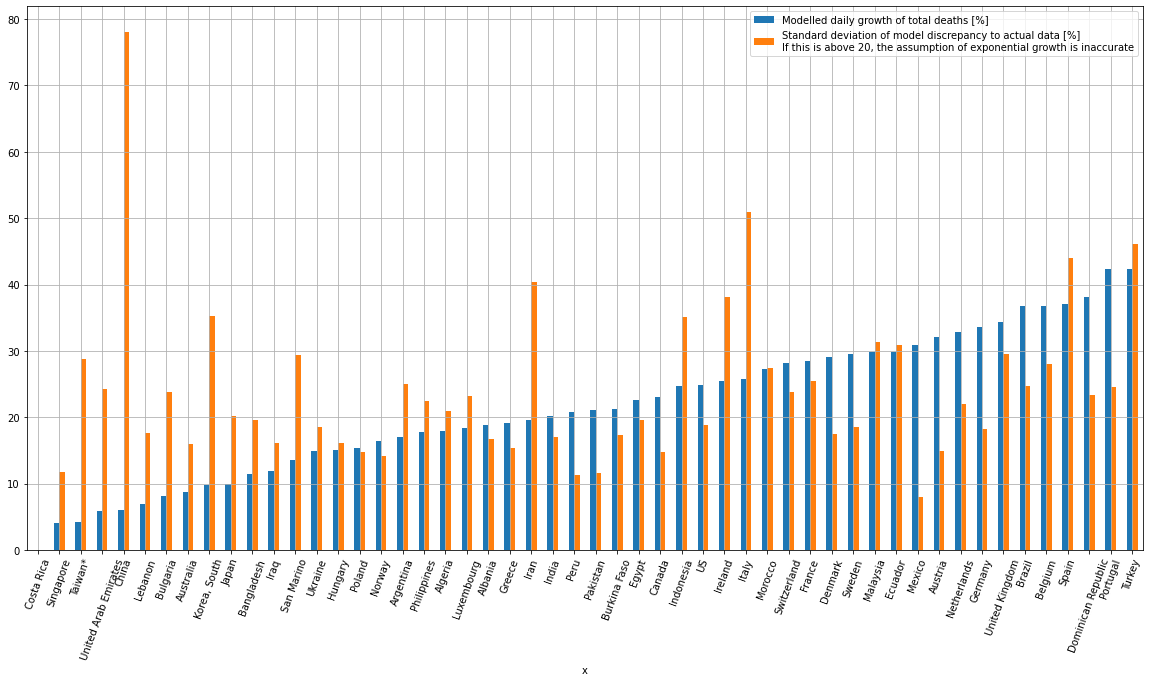

In [24]:
result = dict()
for i, j in df.iterrows():
    a = get_exp_fit(i)
    if a != 0:
        result[i] = a

sorted_result = sorted(result.items(), key=lambda kv: kv[1][0][1])

labels = []
bvalues = []
stddevs = []
for i in sorted_result:
    labels.append(i[0])
    bvalues.append(((np.exp(i[1][0][1]))-1)*100)
    stddevs.append(i[1][1]*100)

df2 = pd.DataFrame({'x' : labels, 'y' : bvalues, 'stderr' : stddevs})
df2.set_index("x",drop=True,inplace=True)
ax = df2.plot(kind="bar")
ax.legend(["Modelled daily growth of total deaths [%]", "Standard deviation of model discrepancy to actual data [%]" + "\n" + "If this is above 20, the assumption of exponential growth is inaccurate"])

plt.xticks(rotation=70)
plt.grid()
plt.rcParams["figure.figsize"] = (20,10)

plt.show()

c:\users\simvel\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


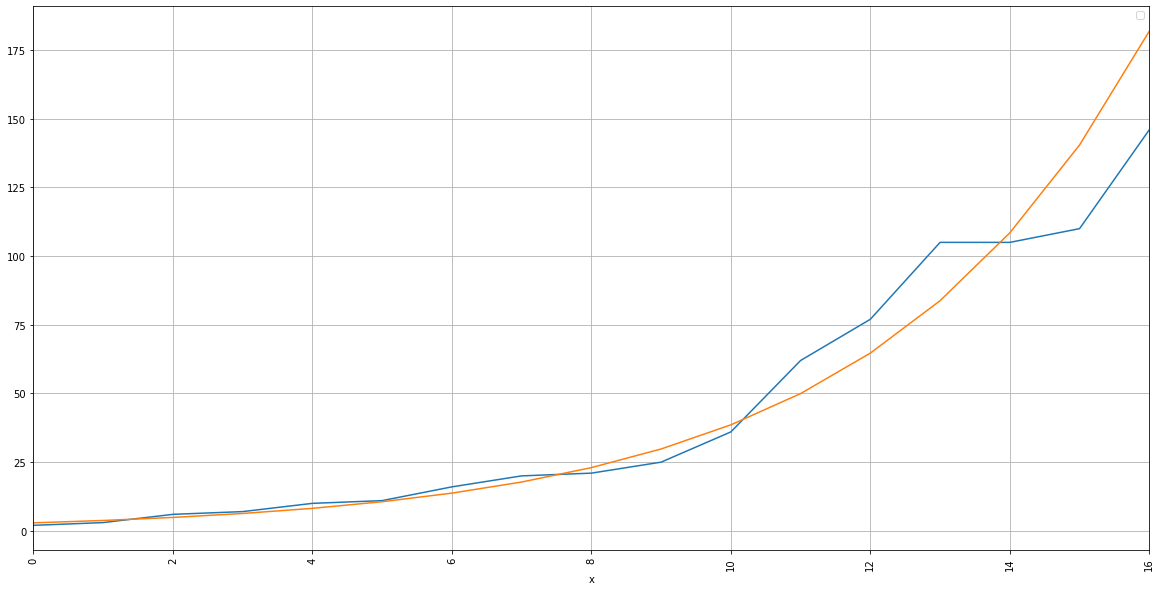

In [44]:
fit = get_exp_fit("Sweden")

labels = []
values = []
model = []
for i in fit[2]:
    labels.append(fit[2][i])
    values.append(fit[3][i])
    model.append(fit[4][i])

df2 = pd.DataFrame({'x' : labels, 'y' : values, 'ymodel' : model})
df2.set_index("x",drop=True,inplace=True)
ax = df2.plot()
ax.legend([])

plt.xticks(rotation=90)
plt.grid()
#plt.yscale("log")
plt.rcParams["figure.figsize"] = (20,10)

plt.show()

c:\users\simvel\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
c:\users\simvel\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


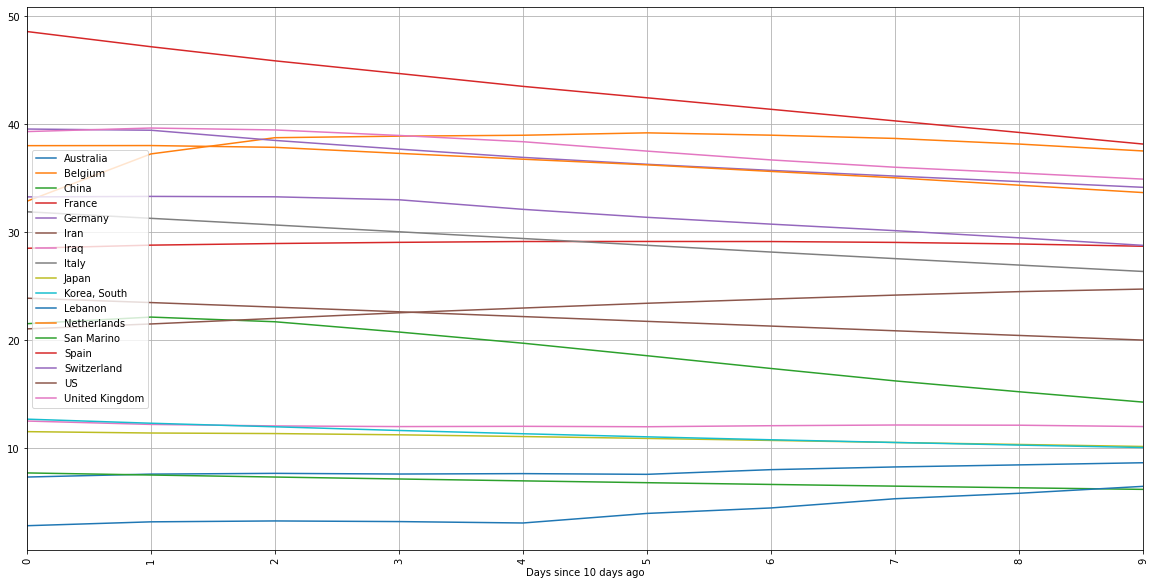

In [27]:
result = dict()
for i, j in df.iterrows():
    lol = []
    lengthlol = 10
    for k in range(lengthlol,0,-1):
        a = get_exp_fit(i, k)
        if a != 0:
            lol.append(a)
            
    if len(lol) > lengthlol-1:
        result[i] = lol

values = dict()
for countryEntry in result.items():
    lool = []
    for expFit in countryEntry[1]:
        lool.append(((np.exp(expFit[0][1]))-1)*100)
    
    values[countryEntry[0]] = lool
    
df2 = pd.DataFrame.from_dict(values)
ax = df2.plot()

plt.xlabel("Days since 10 days ago")
plt.xticks(rotation=90)
plt.grid()
plt.rcParams["figure.figsize"] = (20,10)

plt.show()

c:\users\simvel\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
c:\users\simvel\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


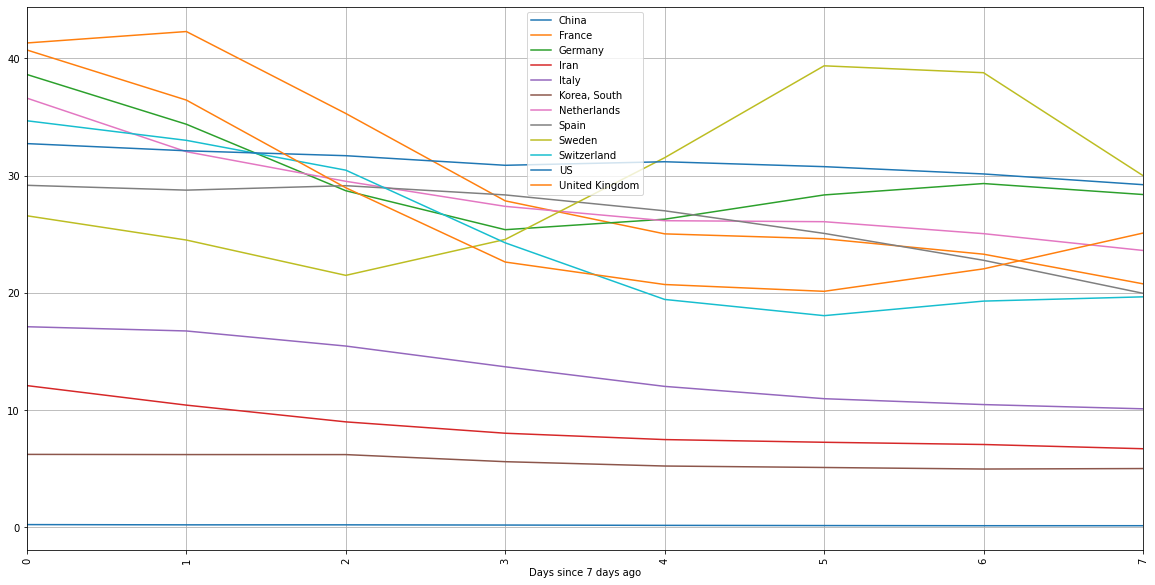

In [52]:
result = dict()
for i, j in df.iterrows():
    lol = []
    lengthlol = 10
    movingAverageLengthlol = 5
    for k in range(lengthlol,0,-1):
        a = get_exp_fit(i, k, movingAverageLengthlol)
        if a != 0:
            lol.append(a)
            
    if len(lol) > lengthlol-1 and lol[0][3][movingAverageLengthlol-1] > 50 or i == "Sweden":
        result[i] = lol

values = dict()
for countryEntry in result.items():
    lool = []
    for expFit in countryEntry[1]:
        lool.append(((np.exp(expFit[0][1]))-1)*100)
        
    loolsmoothed = []
    for i in range(2, len(lool)):
        loolsmoothed.append((lool[i-2] + lool[i-1] + lool[i])/3)
    
    values[countryEntry[0]] = loolsmoothed
    
df2 = pd.DataFrame.from_dict(values)
ax = df2.plot()

plt.xlabel("Days since 7 days ago")
plt.xticks(rotation=90)
plt.grid()
plt.rcParams["figure.figsize"] = (20,10)

plt.show()